<a href="https://colab.research.google.com/github/ItasNik/TEST/blob/main/!%D0%9F%D1%80%D0%BE%D0%B2%D0%B5%D1%80%D0%BA%D0%B0_%D1%80%D0%B0%D0%B7%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F_%D1%87_2_%22Final_project_ipynb%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import files
# Добавим файл в текущую директорию
uploaded = files.upload()


Saving covid_impact_on_airport_traffic.csv to covid_impact_on_airport_traffic.csv


In [ ]:
# Загрузка данных
df = pd.read_csv('./covid_impact_on_airport_traffic.csv')

# Первичный осмотр данных
df.head()

,AggregationMethod,Date,Version,AirportName,PercentOfBaseline,Centroid,City,State,ISO_3166_2,Country,Geography
0,Daily,2020-04-03,1.0,Kingsford Smith,64,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
1,Daily,2020-04-13,1.0,Kingsford Smith,29,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
2,Daily,2020-07-10,1.0,Kingsford Smith,54,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
3,Daily,2020-09-02,1.0,Kingsford Smith,18,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
4,Daily,2020-10-31,1.0,Kingsford Smith,22,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."


# 2. Моделирование

В нашем датасете целевой переменной может быть "PercentOfBaseline", которая представляет собой процентное изменение трафика аэропорта по сравнению с базовым уровнем. Это позволит нам проанализировать, как пандемия влияет на трафик в различных аэропортах и странах.



In [ ]:
from sklearn.preprocessing import LabelEncoder

# Преобразование столбца с датами в числовой формат
labelencoder = LabelEncoder()
df['Date'] = labelencoder.fit_transform(df['Date'])



In [ ]:
#Преобразование категориальных переменных

categorical_columns = ['AggregationMethod', 'AirportName', 'City', 'State', 'ISO_3166_2', 'Country', 'Weekday']

# Примените One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=categorical_columns)



In [ ]:
#Разделение данных
from sklearn.model_selection import train_test_split

X = df_encoded.drop('PercentOfBaseline', axis=1)
y = df_encoded['PercentOfBaseline']

X = X.drop(['Centroid', 'Geography'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

# BASELINE
from sklearn.linear_model import LinearRegression

baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)


LinearRegression()

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = baseline_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for Baseline: {mse}')


Mean Squared Error for Baseline: 191.60412407774413


In [ ]:
# Попробуем RanndomForestRegressor

from sklearn.ensemble import RandomForestRegressor

# Инициализация модели
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Обучение модели
rf_model.fit(X_train, y_train)

# Предсказание и оценка модели
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Mean Squared Error for RandomForest: {mse_rf}')


Mean Squared Error for RandomForest: 95.29694331034484


In [ ]:
# качество улучшилось

In [ ]:
# подберем параметры


from sklearn.model_selection import GridSearchCV

# Параметры для GridSearch
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Инициализация GridSearch
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)

# Обучение
grid_search.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
print(f'Лучшие параметры: {best_params}')

# Предсказание и оценка с лучшими параметрами
best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
print(f'Mean Squared Error for Best RandomForest: {mse_best_rf}')


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Лучшие параметры: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Mean Squared Error for Best RandomForest: 93.08057038261339


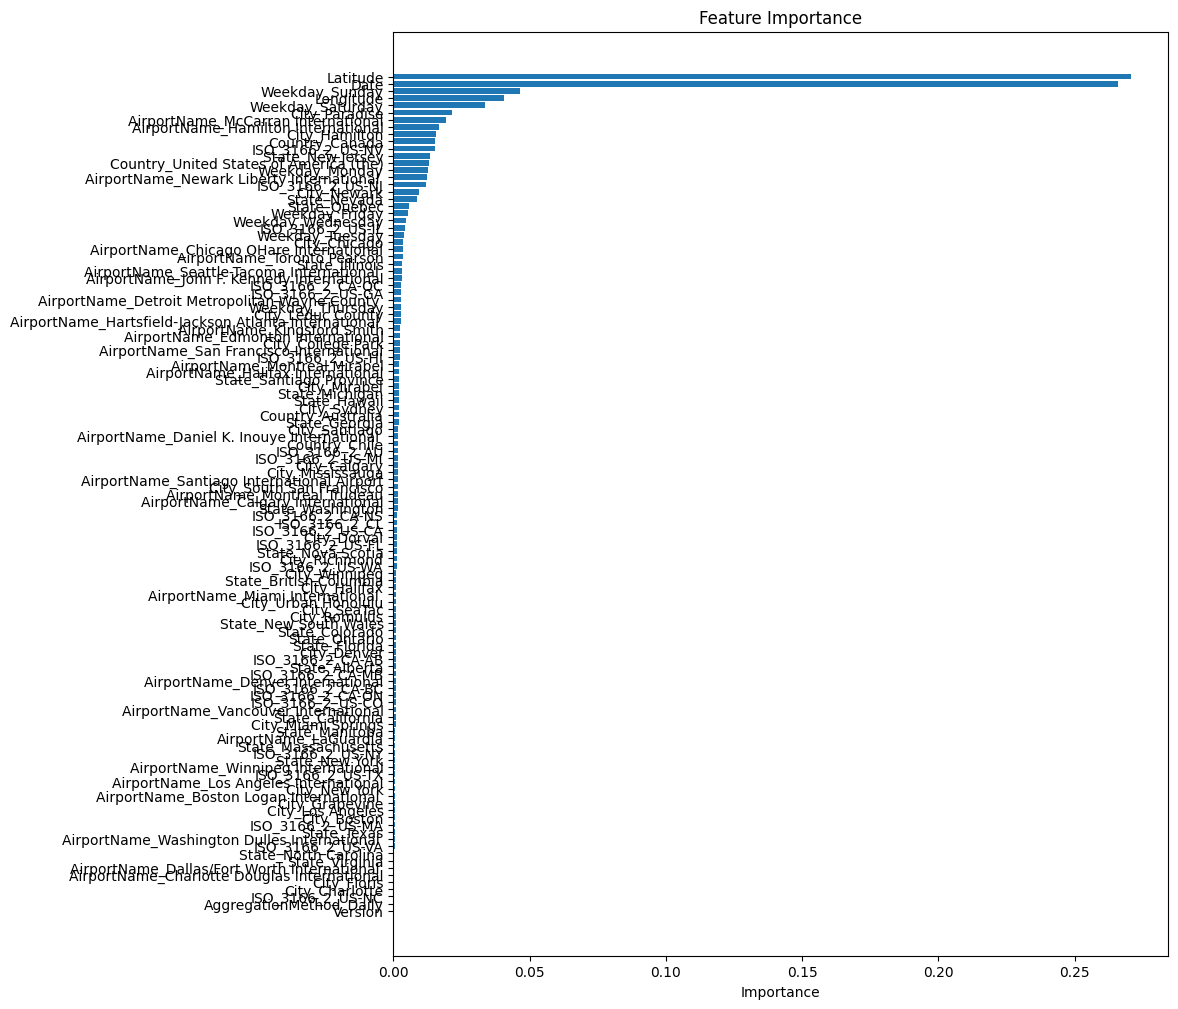

In [ ]:
# Важность признаков
importances = best_rf_model.feature_importances_
feature_names = X_train.columns

# Сортировка признаков по важности
sorted_idx = importances.argsort()

plt.figure(figsize=(10, 12))
plt.barh(range(X_train.shape[1]), importances[sorted_idx], align='center')
plt.yticks(range(X_train.shape[1]), feature_names[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()
